In [1]:
import glob, os, random, re, sys, ast
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from scipy.signal import convolve2d
from scipy import stats
from skimage import io, feature, filters, segmentation, morphology
from ipywidgets import interact, widgets
from IPython.display import set_matplotlib_formats

from colocalization import sharp, extract_mask, mirror_edges, img_to_blocks, scramble, coloc_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_context("notebook")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

<a id='section0'></a>
## FISH colocalization with granules
***

This notebook is part of my master thesis titled: "Single-molecule imaging of mRNA to study translational regulation".

## Colocalization overview

1. [Image import](#section1)
2. [DAPI-gated cellular segmentation](#section2)
3. [Colocalization analysis](#section3)
4. [Spot detection](#section4)
5. [Cell-to-cell measurements](#section5)
6. [Batch processing](#section6)

In this experiment, we wanted to determine if one of three different RNAs (pIM52, pIM52-CMV-5'TOP, ATF-4) is more likely to get recrited to OptoGranules or to Stress granules. For this, Opto-G3BP1 mRuby expressing cells were transfected with one of the three RNAs. Granules were then either induced by light or by sodium arsenite stress. The RNAs were visualized using fluorescent in-situ hybridizaton (FISH). The extent of colocalization between the RNA channel and the OptoGranule / Stress granule channel is measured as shown below.

The previously constructed pipeline for OptoGranule induction will be used to test wether the FISH (mRNA) and the granule signals colocalize. This pipeline will segment cells based on their DAPI signal and measure colocalization as well as count the number of granules in each cell.

Lastly, some of the subsequent code was adapted from the European Molecular Biology Laboratory, Jonas Hartmann, Karin Sasaki, Toby Hodges (© 2018, for cellular segmentation) and from Justin Bois, California Institute of Technology (© 2015, for colocalization in #Functions). Detailed documentation for each function can be found in the accompanying `colocalization.py` file. Everything is distributed under a MIT license.

<a id='section1'></a>
## 1. Image import

First, the images are imported as numpy array. The filetype (here: .stk) must be specified in order to import the correct images. Once imported, the images are displayed for visual inspection. The channels should be labeled as indicated below.

- Image 0 – Nuclear label (eg. DAPI) – here: DAPI, 405 nm
- Image 1 – Colocalization 1 (eg. Halo or IF) – here: OptoG-mRuby, 561 nm
- Image 2 – Colocalization 2 (eg. FISH) – here: FISH-Renilla, 640 nm

The subsequent sharp function is used to determine the sharpest slice of the z-stack images. This is done by measuring the average intensity differences between pixel values.

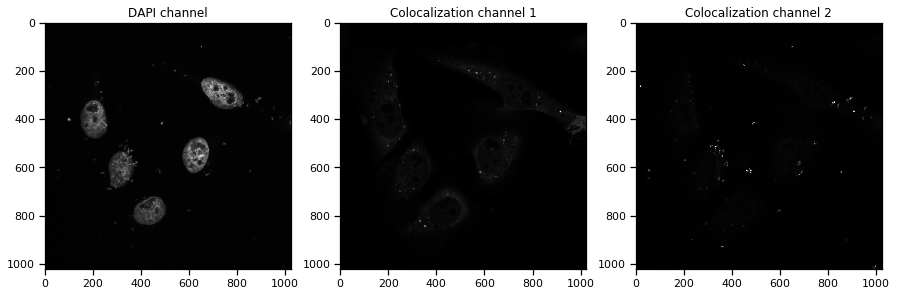

In [2]:
# File path
number = 0
root = 'colocalization_example/'
lambdas = [405, 561, 640]

indices = [file.split('.')[0] for file in os.listdir(root) if file.endswith('.nd')][number]

for index in indices:
    files = glob.glob('{}{}*.stk'.format(root, index))
    
    # Find sharpest image in img2_lambda channel
    for f in files:
        if str(lambdas[2]) in f:
            img_sharp = sharp(io.imread(f))

    # Open all images corresponding to a lambda
    for f in files:
        for i in range(len(lambdas)):
            if str(lambdas[i]) in f:
                globals()['img_'+str(lambdas[i])] = io.imread(f)[img_sharp]
                
# Stack and convert to uint16
img = np.stack([globals()['img_'+str(lambdas[i])] for i in range(len(lambdas))], axis=0)

# Check if images are loaded correctly
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].set_title('DAPI channel')
ax[0].imshow(img[0], interpolation=None, cmap='gray')
ax[1].set_title('Colocalization channel 1')
ax[1].imshow(img[1], interpolation=None, cmap='gray')
ax[2].set_title('Colocalization channel 2')
ax[2].imshow(img[2], interpolation=None, cmap='gray')
plt.show()

<a id='section2'></a>
## 2. DAPI-gated cellular segmentation

To do a cellular analysis, all cells are segmented. The parts of this multi-step process are described below.

**Preprocessing** – To obtain a better segmentation later on, the image acquired through the DAPI channel will be smoothed by a gauss filer. Different sigmas (below) can be used to change 'smoothing intensity'.

**Thresholding** – A global threshold will be applied to remove background noise and to be left with the DAPI nuclei. A variety of thresholding options can be selected. Currently 'otsu' is used.

**Connected component labeling** – As some DAPI nuclei currently show up to be combined, a further smoothing and a exact euclidean distance transform is used to separate these combined nuclei. Thereby, undersegmentation artifacts can be minimized.

**Seeding** – Local maxima are used to detect every DAPI nucleus. This provides a seed for the later segmentation.

**Watershed** – Segmentation using the generated seeds. Inverted watershed or random walker can be used (change name). Cells on the border might slightly skew with the results, but because a 63x objective is required to visualize the FISH spots, removing these cells would result in only very few (if any) cells remaining per image. Furthermore colocalization is analyzed and not total spot count.

**Nuclei** – Dilate nuclei (more space around nuclei) and substract these from the watershed segmentation. Therefore, one is left with only the cytoplasms and the image background.

**Background** – A threshold based approach in the first colocalization channel to remove background. As the removal on a cellular basis and would mess up labelling, the background is shown as whole.

**Debris** – Removal of small segments which are too small to be 'real' cytoplasm.

**Relabeling** – To have a continuous label, every segmented area is relabeled.

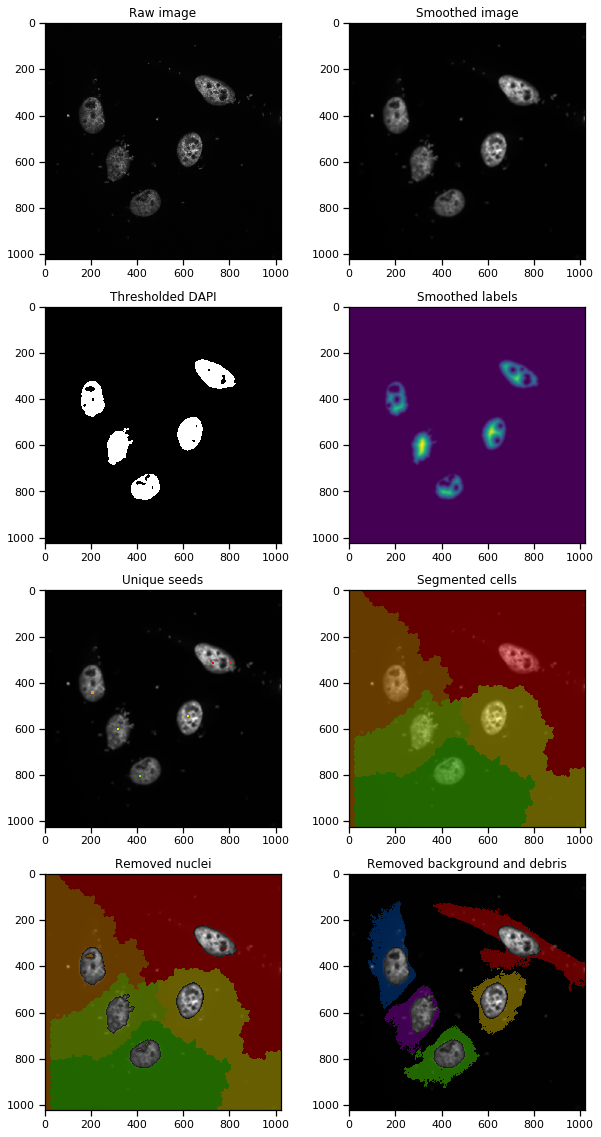

In [3]:
# Parameters for cellular segmentation
img0_sigma = 3
img0_min_size = 300
img0_min_distance = 50
img0_dilation = 5
img0_thresh_bg = 1_000
img0_min_size_bg = 5_000

# Gauss-smoothening
img0_smooth = ndi.filters.gaussian_filter(img[0], img0_sigma)

# Thresholding and removal of small objects
img0_thresh = filters.threshold_otsu(img0_smooth)
img0_smooth_thresh = img0_smooth>img0_thresh
img0_mem = morphology.remove_small_objects(img0_smooth_thresh, img0_min_size)

# Labeling, euclidean distance transform, smoothing
img0_dist_trans = ndi.distance_transform_edt(img0_mem)
img0_dist_trans_smooth = ndi.filters.gaussian_filter(img0_dist_trans, sigma=img0_sigma)

# Seeding (and dilating for visualization)
img0_seeds = feature.peak_local_max(img0_dist_trans_smooth, indices=False, min_distance=img0_min_distance)
img0_seeds_labeled, _ = ndi.label(img0_seeds)
img0_seeds_labeled_dil = ndi.filters.maximum_filter(img0_seeds_labeled, size=10)

# Inverted watershed for segmentation
img0_seg = segmentation.watershed(~img0_smooth, img0_seeds_labeled)

# Removal of dilated nuclei
img0_kernel = morphology.selem.diamond(img0_dilation)
img0_seg_nuclei = img0_seg * ~convolve2d(img0_mem.astype(int), img0_kernel.astype(int), mode='same').astype(bool)

# Removal of background based on colocalization channel 1
#img0_thresh_bg = filters.threshold_triangle(img[1])
img0_smooth_thresh_bg = img[1]>img0_thresh_bg
img0_seg_clean = img0_seg_nuclei * img0_smooth_thresh_bg

# Removal of 'debris'
img0_seg_labeled, img0_seg_labels = ndi.measurements.label(img0_seg_clean)
img0_seg_label_size = [(img0_seg_labeled == label).sum() for label in range(img0_seg_labels + 1)]
for label, size in enumerate(img0_seg_label_size):
    if size < img0_min_size_bg:
        img0_seg_clean[img0_seg_labeled == label] = 0

# Relabel in case 'debris' was removed
new_ID = 1
for curr_ID in np.unique(img0_seg_clean)[1:]:
    if not len(img0_seg_clean[img0_seg_clean==curr_ID]) == 0:
        img0_seg_clean[img0_seg_clean==curr_ID] = new_ID
        new_ID += 1

# Visualization
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
ax[0,0].set_title('Raw image')
ax[0,0].imshow(img[0], interpolation='none', cmap='gray')
ax[0,1].set_title('Smoothed image')
ax[0,1].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[1,0].set_title('Thresholded DAPI')
ax[1,0].imshow(img0_mem, interpolation='none', cmap='gray')
ax[1,1].set_title('Smoothed labels')
ax[1,1].imshow(img0_dist_trans_smooth, interpolation='none', cmap='viridis')
ax[2,0].set_title('Unique seeds')
ax[2,0].imshow(img0_dist_trans_smooth, interpolation='none', cmap='viridis')
ax[2,0].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[2,0].imshow(np.ma.array(img0_seeds_labeled_dil, mask=img0_seeds_labeled_dil==0), interpolation='none', cmap='prism')
ax[2,1].set_title('Segmented cells')
ax[2,1].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[2,1].imshow(np.ma.array(img0_seg, mask=img0_seg==0), interpolation='none', cmap='prism', alpha=0.4)
ax[3,0].set_title('Removed nuclei')
ax[3,0].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[3,0].imshow(np.ma.array(img0_seg_nuclei, mask=img0_seg_nuclei==0), interpolation='none', cmap='prism', alpha=0.4)
ax[3,1].set_title('Removed background and debris')
ax[3,1].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[3,1].imshow(np.ma.array(img0_seg_clean, mask=img0_seg_clean==0), interpolation='none', cmap='prism', alpha=0.4)
plt.show()

<a id='section3'></a>
## 3. Colocalization analysis

The pearson correlation coefficient (PCC) can be used to quantify colocalization with a intensity weight. The equation is shown below.

\begin{align}
r = \frac{\sum_i\left(I_{1,i} - \bar{I}_1\right)\left(I_{2,i} - \bar{I}_2\right)}{\sqrt{\left(\sum_i \left(I_{1,i} - \bar{I}_1\right)^2\right)\left(\sum_i \left(I_{2,i} - \bar{I}_2\right)^2\right)}}.
\end{align}

The image set is tested for statistical relevance i.e. if the colocalization is greater than simple variance. This is done via scrambling small blocks of the image. The blocks' height and width are equal to the point spread function (PSF). The PCC is then calculated on the scrambled image blocks. The PSF can be approximated using the rayleigh criterion, which in case of these images / microscopes is as follows.

\begin{align}
R_{\text{Confocal}} = \frac{0.4 \times \lambda}{\text{NA}} = \frac{0.4 \times 640\text{ nm}}{1.45} = 278\text{ nm} \rightarrow \text{PSF} \approx 3\text{ px}
\end{align}

Due to the fact that the PSF is close to one pixel, every pixel will be scrambled inside the segmented cellular area. Alternatively – if the PSF were larger – the edges would be mirrored to obtain an image that is a multiple of the PSF. This, however, due to the cellular segmentation (resulting in uneven shapes) is not possible. The widget below can be used to visualize the effect of scrambling on the r-value.

In [41]:
def test_coloc(img1, img2, psf=3, scrambles=200):
    # Mirror edges
    img1_mirror = mirror_edges(img1, psf)
    img2_mirror = mirror_edges(img2, psf)

    # Generate blocks of both channels
    img1_blocks = img_to_blocks(img1_mirror, psf)
    img2_blocks = img_to_blocks(img2_mirror, psf)

    # Store blocks of channel 2 as flattened array (not scrambled)
    img2_blocks_flat = np.array(img2_blocks).flatten()

    # Unscrambled and scrambled R value(s)
    img1_unscr, p = stats.pearsonr(np.array(img1_blocks).ravel(), img2_blocks_flat)
    img1_scr = scramble(img1_blocks, img2_blocks_flat, scrambles)
    img1_prob = sum(i > img1_unscr for i in img1_scr) / len(img1_scr)
    print('Probability of statistical error: ', img1_prob)
    
    # Visualization
    _ = sns.distplot(img1_scr, bins=int(np.sqrt(scrambles)), label='Scrambles')
    plt.plot([img1_unscr, img1_unscr], plt.gca().get_ylim(), '-', label='Real image')
    plt.title('Scrambled histogram vs. "real" image')
    plt.xlabel('* colococalization coefficient')
    plt.xlim(-1, 1)
    plt.yticks([])
    plt.ylabel(None)
    plt.legend(frameon=False)
    sns.despine(trim=True, bottom=False, left=True)
    #plt.savefig('colocalization.pdf', bbox_inches='tight') 
    plt.show()

Probability of statistical error:  0.0


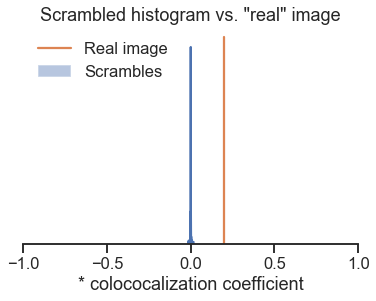

In [42]:
@interact(t_scrambles = widgets.IntSlider(min=0, max=2000, step=10, value=100, description='Scrambles: '),
          t_cell = widgets.IntSlider(min=1, max=len(np.unique(img0_seg_clean)), value=1, description='Cell: '))
def g(t_scrambles, t_cell):
    test_img1 = extract_mask(img0_seg_clean==t_cell, img[1])
    test_img2 = extract_mask(img0_seg_clean==t_cell, img[2])
    test_coloc(test_img1, test_img2, 3, t_scrambles)

<a id='section4'></a>
## 4. Spot detection

To find optimal spot detection parameters in the second image channel, the widgets below can be used. In this pipeline, the spot detection is used filter out false positives. Cells, for example, which don't have any spots but seem to have significant colocalization values.

In [52]:
def test_spot_counter(image, sigma, block_size, thresh_abs, min_distance):
    # Set thresholds to reduce noise
    test_smooth = ndi.filters.gaussian_filter(image, sigma)
    thresh = filters.threshold_local(test_smooth, block_size, offset=0) 
    
    # Find and label seeds
    seeds = feature.peak_local_max(thresh, indices=False, min_distance=min_distance, threshold_abs=thresh_abs)
    seeds_labeled, _ = ndi.label(seeds)
    seeds_labeled_dil = ndi.filters.maximum_filter(seeds_labeled, size=10) # Dilates seeds – more visible
    seeds_masked_labeled = np.ma.array(seeds_labeled_dil, mask=seeds_labeled_dil==0)
    seeds_unique = len(np.unique(seeds_labeled_dil)[1:])
    
    # Visualization
    plt.figure(figsize=(10, 10))
    plt.title('Detected spots')
    plt.imshow(image, interpolation='none', cmap='gray')
    plt.imshow(seeds_masked_labeled, interpolation='none', cmap='prism', alpha=0.5)
    #plt.savefig('spot_counter.pdf')
    print('Unique spots:', seeds_unique)

Unique spots: 77


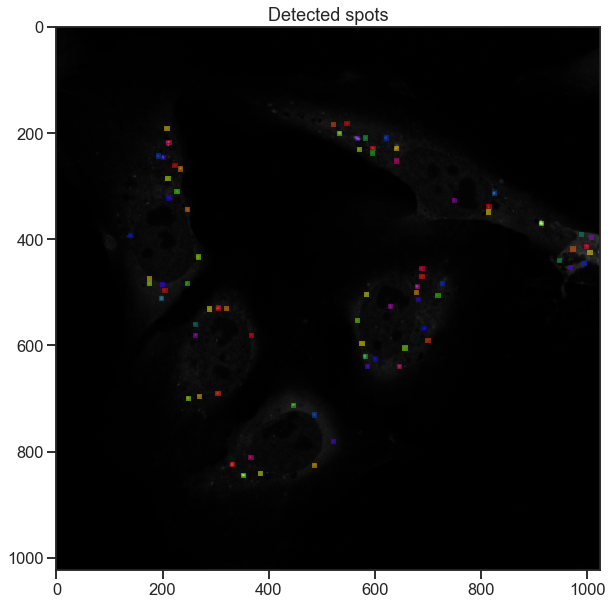

In [53]:
@interact(t_img = widgets.ToggleButtons(options=['1', '2'], description='Channel: '),
         t_sigma = widgets.IntSlider(min=0, max=20, step=1, value=1, description='Sigma: '),
         t_block_size = widgets.IntSlider(min=1, max=21, step=2, value=5, description='Block size: '),
         t_thresh_abs = widgets.IntSlider(min=0, max=15_000, step=100, value=7_000, description='Treshold: '),
         t_min_distance = widgets.IntSlider(min=0, max=30, step=1, value=5, description='Min. dist.: '))
def g(t_img, t_sigma, t_block_size, t_thresh_abs, t_min_distance):
    test_img = img[int(t_img)]
    test_spot_counter(test_img, t_sigma, t_block_size, t_thresh_abs, t_min_distance)

# Alternatively, use
# test_img = img[int(t_img)]
# test_spot_counter(test_img, t_sigma, t_block_size, t_thresh_abs, t_min_distance)

<a id='section5'></a>
## 5. Cell-to-cell measurements

The colocalization and spot detection functions will be used to record their respective output on a cellular basis. In order to track the settings used for the analysis, all parameters are saved together with the measurements. Prior to the measurements, the background will be substracted as represented above ([DAPI-gated cellular segmentation](#section2)). All values are combined and stored in a .csv file.

In [ ]:
def coloc(img1, img2, mirror=True, psf=3, scrambles=200):
    # Mirror edges
    if mirror:
        img1_mirror = mirror_edges(img1, psf)
        img2_mirror = mirror_edges(img2, psf)
    if not mirror:
        img1_mirror = img1
        img2_mirror = img2

    # Generate blocks of both channels
    img1_blocks = img_to_blocks(img1_mirror, psf)
    img2_blocks = img_to_blocks(img2_mirror, psf)

    # Store blocks of channel 2 as flattened array (not scrambled)
    img2_blocks_flat = np.array(img2_blocks).flatten()

    # Scamblin' and obtain R value
    img1_scr = scramble(img1_blocks, img2_blocks_flat, scrambles)
    
    # Unscrambled R value
    img1_unscr, p = stats.pearsonr(np.array(img1_blocks).ravel(), img2_blocks_flat)
    
    # Probablity
    img1_prob = sum(i > img1_unscr for i in img1_scr) / len(img1_scr)
    
    return img1_unscr, img1_scr, img1_prob

In [ ]:
def coloc_cell(img0, img1, img2, scrambles=200):
    img1_seg = img1 * img0
    img2_seg = img2 * img0
    r_unscr, _ = stats.pearsonr(img1_seg.flatten(), img2_seg.flatten())
    r_scr = []
    for _ in range(scrambles):
        img1_flat = img1.flatten()
        idx, = np.nonzero(img1_flat)
        img1_flat[idx] = img1_flat[np.random.permutation(idx)]
        img1_flat = img1_flat.reshape(img1_seg.shape)
        r, _ = stats.pearsonr(img1_flat.flatten(), img2_seg.flatten())
        r_scr.append(r)
        
    r_prob = sum(i > r_unscr for i in r_scr) / len(r_scr)
    
    return r_unscr, r_scr, r_prob

In [ ]:
def spot_counter(img_, block_size=1, threshold=0, min_distance=0):
    thresh = filters.threshold_local(img_, block_size, offset=5) 
    seeds = feature.peak_local_max(thresh, indices=False, min_distance=min_distance)
    seeds_labeled, _ = ndi.label(seeds)
    seeds_unique = len(np.unique(seeds_labeled)[1:]) # '0' to not include background
    return seeds_unique

In [ ]:
img1_sigma = 1
img1_block_size = 5
img1_min_distance = 5
img1_thresh = 7000
img2_sigma = 2
img2_block_size = 5
img2_min_distance = 0
img2_thresh = 8000

In [ ]:
df = pd.DataFrame()

# Smoothing for spot detection
img1_smooth = ndi.filters.gaussian_filter(img[1], img1_sigma)
img2_smooth = ndi.filters.gaussian_filter(img[2], img2_sigma)
unscr_image, scr_image, prob_image = coloc(img[1], img[2])

for cell_ID in np.unique(img0_seg_clean)[1:]:
    img0_cell_mask = img0_seg_clean==cell_ID
    img1_cell = np.where(np.ma.array(img0_cell_mask, mask=img0_cell_mask==0), img1_smooth, 0)
    img2_cell = np.where(np.ma.array(img0_cell_mask, mask=img0_cell_mask==0), img2_smooth, 0)
    
    img1_coloc, img2_coloc = extract_mask(img0_cell_mask, img[1]), extract_mask(img0_cell_mask, img[2])
    unscr_cellbox, scr_cellbox, prob_cellbox = coloc(img1_coloc, img2_coloc, mirror=False)
    unscr_cellmask, scr_cellmask, prob_cellmask = coloc_cell(img0_cell_mask, img[1], img[2])
    
    df = df.append({'filename' : files[0],
                    'cell_ID' : cell_ID,
                    'cell_area' : np.count_nonzero(img0_cell_mask),
                    'img1_cell_intensity_mean' : np.mean(np.nonzero(img1_cell)),
                    'img1_cell_intensity_std' : np.std(np.nonzero(img1_cell)),
                    'img1_spot_count' : spot_counter(img1_cell, img1_block_size, img1_thresh, img1_min_distance),
                    'img2_cell_intensity_mean' : np.mean(np.nonzero(img2_cell)),
                    'img2_cell_intensity_std' : np.std(np.nonzero(img2_cell)),
                    'img2_spot_count' : spot_counter(img2_cell, img2_block_size, img2_thresh, img2_min_distance),
                    'img1_2_coloc_unscr_image' : unscr_image,
                    'img1_2_coloc_scr_image' : scr_image,
                    'img1_2_coloc_prob_image' : prob_image,
                    'img1_2_coloc_unscr_cellbox' : unscr_cellbox,
                    'img1_2_coloc_scr_cellbox' : scr_cellbox,
                    'img1_2_coloc_prob_cellbox' : prob_cellbox,
                    'img1_2_coloc_unscr_cellmask' : unscr_cellmask,
                    'img1_2_coloc_scr_cellmask' : scr_cellmask,
                    'img1_2_coloc_prob_cellmask' : prob_cellmask},
                   ignore_index=True)

df.to_csv(f'{files[0]}.csv', index=False)

<a id='section6'></a>
## 6. Batch processing

Batch processing means running complete pipeline over multiple images. The run_pipeline function is located in the file colocalization.py together with all dependencies and helper functions. Simply run the following code in the terminal.

```bash
python colocalization.py -folder='PATH_TO_FOLDER'
```